# Data exploration for SeroTracker
### Author: Hailey Robertson
### Date: 2024-09-26
### Citations:
- Whelan, Mairead G, Harriet Ware, Himanshu Ranka, Sean Kenny, Sabah Shaikh, Yannik Roell, Shaila Akter, et al. “Arbotracker: A Multipathogen Dashboard and Data Platform for Arbovirus Seroprevalence Studies.” The Lancet Infectious Diseases, September 10, 2024. https://doi.org/10.1016/s1473-3099(24)00585-1


## Imports and figure constants

In [1]:
# import

import pandas as pd
import numpy as np
from itertools import chain
from scipy import stats
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.colors import rgb2hex
from PIL import ImageColor
import geopandas as gpd
import geodatasets as geoda
import datetime as dt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import font_manager
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from seaborn.matrix import _HeatMapper
from six import string_types
from seaborn.utils import despine, axis_ticklabels_overlap, relative_luminance, to_utf8
import time
import string
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Define gradient color
gradient = ['#E7EAEE','#96B7D6', '#001842']
cm = LinearSegmentedColormap.from_list(
        "Custom", gradient, N=100)

# Define chart skeleton color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']

# Color palette
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']

# Define constants
figure_size = (20,6)

pd.set_option('display.max_columns', None)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.1

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 14

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = -35
plt.rcParams["ytick.minor.pad"] = -35
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 14

# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.7

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125

# Set axis labels
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = chart[1]

## Load data

In [3]:
sero_df = pd.read_csv('../data/serotracker_estimates_2024-09-24.csv')

# Filter out children because immunologically naive and filter for dengue pathogen
adult_sero = sero_df[(sero_df['ageGroup'] == 'Adults (18-64 years)') | 
                     ((sero_df['ageGroup'] == 'Multiple groups') & (sero_df['ageMinimum'] == 18))]

adult_sero = adult_sero[(adult_sero['pathogen'] == 'DENV')]

adult_sero = adult_sero.sort_values(by="country",ascending=True)

In [4]:
adult_sero.head()

,id,estimateId,pathogen,serotype,country,countryAlphaTwoCode,countryAlphaThreeCode,sampleStartDate,sampleEndDate,seroprevalence,city,state,latitude,longitude,unRegion,whoRegion,seroprevalenceStudy95CILower,seroprevalenceStudy95CIUpper,seroprevalenceCalculated95CILower,seroprevalenceCalculated95CIUpper,sampleSize,sampleNumerator,sampleFrame,antibodies,assay,assayOther,sameFrameTargetGroup,antigen,inclusionCriteria,ageGroup,ageMinimum,ageMaximum,pediatricAgeGroup,sex,url,sourceSheetId,sourceSheetName,createdAt,producer,producerOther
888,66c79a909f0787fb1e4560df,140912_Naval Medical Research Unit_Afghanistan...,DENV,NaN,Afghanistan,AF,AFG,2008-06-15 06:00:00+00:00,2010-06-15 06:00:00+00:00,0.0260,NaN,NaN,33.918134,65.963102,SOUTHERN_ASIA,EMR,NaN,NaN,0.011134,0.049896,312,8.0,Inpatients,['IgM'],ELISA,NaN,NaN,NaN,Starting in 2008 through 2010; patients were e...,Adults (18-64 years),20.0,59.0,NaN,All,https://doi.org/10.3855/jidc.4183,recEQxwhUkDRXREWM,Serological evidence of flaviviruses infection...,2024-08-22 20:07:44.559000+00:00,Panbio,NaN
736,66c79a909f0787fb1e45608e,140912_Naval Medical Research Unit_Afghanistan...,DENV,NaN,Afghanistan,AF,AFG,2008-06-15 06:00:00+00:00,2010-06-15 06:00:00+00:00,0.1970,NaN,NaN,33.742627,65.936400,SOUTHERN_ASIA,EMR,NaN,NaN,0.171809,0.224466,913,180.0,Inpatients,['IgG'],ELISA,NaN,NaN,NaN,Starting in 2008 through 2010; patients were e...,Adults (18-64 years),20.0,59.0,NaN,All,https://doi.org/10.3855/jidc.4183,recEQxwhUkDRXREWM,Serological evidence of flaviviruses infection...,2024-08-22 20:07:44.559000+00:00,Panbio,NaN
308,66c79a909f0787fb1e455e46,230415_UniversityofCampinas_Brazil_DENV_age20-...,DENV,NaN,Brazil,BR,BRA,2015-01-15 07:00:00+00:00,2015-12-15 07:00:00+00:00,0.9500,Manaus,Amazonas,-3.041168,-60.009943,SOUTH_AMERICA,AMR,NaN,NaN,0.888245,0.983733,101,96.0,Community,"['IgG', 'IgM']",HAI,NaN,The study population comprised healthy individ...,NaN,The study included individuals of both sexes a...,Adults (18-64 years),20.0,29.0,NaN,All,https://www.ijidonline.com/article/S1201-9712(...,recmt1GbeIHSFyPli,Antibody cross-reactivity and evidence of susc...,2024-08-22 20:07:44.559000+00:00,NaN,NaN
997,66c79a909f0787fb1e456118,190325_UnivBrasilia_Haddad_DENV_IgGM_Female,DENV,NaN,Brazil,BR,BRA,2015-12-15 07:00:00+00:00,2016-05-15 06:00:00+00:00,0.0375,NaN,NaN,-9.547631,-51.654897,SOUTH_AMERICA,AMR,NaN,NaN,0.013884,0.079832,160,6.0,Blood donors,"['IgM', 'IgG']",ELISA,NaN,Blood Donors,anti-DENV,Blood Donors at the blood center of Brasilia,Adults (18-64 years),NaN,NaN,NaN,Female,https://journals.plos.org/plosone/article?id=1...,rec1pZLY3DS84qPBt,Dengue seroprevalence among asymptomatic blood...,2024-08-22 20:07:44.559000+00:00,Euroimmun,NaN
948,66c79a909f0787fb1e45606e,230415_UniversityofCampinas_Brazil_DENV_age40-...,DENV,NaN,Brazil,BR,BRA,2015-01-15 07:00:00+00:00,2015-12-15 07:00:00+00:00,0.9420,Manaus,Amazonas,-3.054844,-59.915495,SOUTH_AMERICA,AMR,NaN,NaN,0.877513,0.978325,103,97.0,Community,"['IgG', 'IgM']",HAI,NaN,The study population comprised healthy individ...,NaN,The study included individuals of both sexes a...,Adults (18-64 years),40.0,49.0,NaN,All,https://www.ijidonline.com/article/S1201-9712(...,recmt1GbeIHSFyPli,Antibody cross-reactivity and evidence of susc...,2024-08-22 20:07:44.559000+00:00,NaN,NaN


### Where are the dengue adult seroprevalence studies?

In [5]:
# World geometry shapefile, devastating that get_path("naturalearth_lowres") was deprecated 
world = gpd.read_file("../data/ne_110m_admin_0_countries")
world = world.rename(columns={"ADM0_A3":"countryAlphaThreeCode",
                              "ADMIN":"country"})
cols = ['country','countryAlphaThreeCode','geometry']
world = world[cols]
world = world.sort_values(by="countryAlphaThreeCode")

# Fix known issues in geopandas
world.loc[world['country'] == 'France', 'countryAlphaThreeCode'] = 'FRA'
world.loc[world['country'] == 'Norway', 'countryAlphaThreeCode'] = 'NOR'
world.loc[world['country'] == 'Somaliland', 'countryAlphaThreeCode'] = 'SOM'
world.loc[world['country'] == 'Kosovo', 'countryAlphaThreeCode'] = 'RKS'

# Merge geometry, keeping nulls
adults_geo = pd.merge(world,adult_sero,on='countryAlphaThreeCode')

# Deal with columns with `_x` and `_y` suffixes
columns_to_rename = {col: col.replace('_x', '') for col in adults_geo.columns if '_x' in col}
columns_to_drop = [col for col in adults_geo.columns if '_y' in col]

# Rename the '_x' columns to their original names
adults_geo = adults_geo.rename(columns=columns_to_rename)

# Drop the '_y' columns
adults_geo = adults_geo.drop(columns=columns_to_drop)

adults_geo.head()

,country,countryAlphaThreeCode,geometry,id,estimateId,pathogen,serotype,countryAlphaTwoCode,sampleStartDate,sampleEndDate,seroprevalence,city,state,latitude,longitude,unRegion,whoRegion,seroprevalenceStudy95CILower,seroprevalenceStudy95CIUpper,seroprevalenceCalculated95CILower,seroprevalenceCalculated95CIUpper,sampleSize,sampleNumerator,sampleFrame,antibodies,assay,assayOther,sameFrameTargetGroup,antigen,inclusionCriteria,ageGroup,ageMinimum,ageMaximum,pediatricAgeGroup,sex,url,sourceSheetId,sourceSheetName,createdAt,producer,producerOther
0,Afghanistan,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",66c79a909f0787fb1e4560df,140912_Naval Medical Research Unit_Afghanistan...,DENV,NaN,AF,2008-06-15 06:00:00+00:00,2010-06-15 06:00:00+00:00,0.0260,NaN,NaN,33.918134,65.963102,SOUTHERN_ASIA,EMR,NaN,NaN,0.011134,0.049896,312,8.0,Inpatients,['IgM'],ELISA,NaN,NaN,NaN,Starting in 2008 through 2010; patients were e...,Adults (18-64 years),20.0,59.0,NaN,All,https://doi.org/10.3855/jidc.4183,recEQxwhUkDRXREWM,Serological evidence of flaviviruses infection...,2024-08-22 20:07:44.559000+00:00,Panbio,NaN
1,Afghanistan,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",66c79a909f0787fb1e45608e,140912_Naval Medical Research Unit_Afghanistan...,DENV,NaN,AF,2008-06-15 06:00:00+00:00,2010-06-15 06:00:00+00:00,0.1970,NaN,NaN,33.742627,65.936400,SOUTHERN_ASIA,EMR,NaN,NaN,0.171809,0.224466,913,180.0,Inpatients,['IgG'],ELISA,NaN,NaN,NaN,Starting in 2008 through 2010; patients were e...,Adults (18-64 years),20.0,59.0,NaN,All,https://doi.org/10.3855/jidc.4183,recEQxwhUkDRXREWM,Serological evidence of flaviviruses infection...,2024-08-22 20:07:44.559000+00:00,Panbio,NaN
2,Brazil,BRA,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",66c79a909f0787fb1e455e46,230415_UniversityofCampinas_Brazil_DENV_age20-...,DENV,NaN,BR,2015-01-15 07:00:00+00:00,2015-12-15 07:00:00+00:00,0.9500,Manaus,Amazonas,-3.041168,-60.009943,SOUTH_AMERICA,AMR,NaN,NaN,0.888245,0.983733,101,96.0,Community,"['IgG', 'IgM']",HAI,NaN,The study population comprised healthy individ...,NaN,The study included individuals of both sexes a...,Adults (18-64 years),20.0,29.0,NaN,All,https://www.ijidonline.com/article/S1201-9712(...,recmt1GbeIHSFyPli,Antibody cross-reactivity and evidence of susc...,2024-08-22 20:07:44.559000+00:00,NaN,NaN
3,Brazil,BRA,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",66c79a909f0787fb1e456118,190325_UnivBrasilia_Haddad_DENV_IgGM_Female,DENV,NaN,BR,2015-12-15 07:00:00+00:00,2016-05-15 06:00:00+00:00,0.0375,NaN,NaN,-9.547631,-51.654897,SOUTH_AMERICA,AMR,NaN,NaN,0.013884,0.079832,160,6.0,Blood donors,"['IgM', 'IgG']",ELISA,NaN,Blood Donors,anti-DENV,Blood Donors at the blood center of Brasilia,Adults (18-64 years),NaN,NaN,NaN,Female,https://journals.plos.org/plosone/article?id=1...,rec1pZLY3DS84qPBt,Dengue seroprevalence among asymptomatic blood...,2024-08-22 20:07:44.559000+00:00,Euroimmun,NaN
4,Brazil,BRA,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",66c79a909f0787fb1e45606e,230415_UniversityofCampinas_Brazil_DENV_age40-...,DENV,NaN,BR,2015-01-15 07:00:00+00:00,2015-12-15 07:00:00+00:00,0.9420,Manaus,Amazonas,-3.054844,-59.915495,SOUTH_AMERICA,AMR,NaN,NaN,0.877513,0.978325,103,97.0,Community,"['IgG', 'IgM']",HAI,NaN,The study population comprised healthy individ...,NaN,The study included individuals of both sexes a...,Adults (18-64 years),40.0,49.0,NaN,All,https://www.ijidonline.com/article/S1201-9712(...,recmt1GbeIHSFyPli,Antibody cross-reactivity and evidence of susc...,2024-08-22 20:07:44.559000+00:00,NaN,NaN


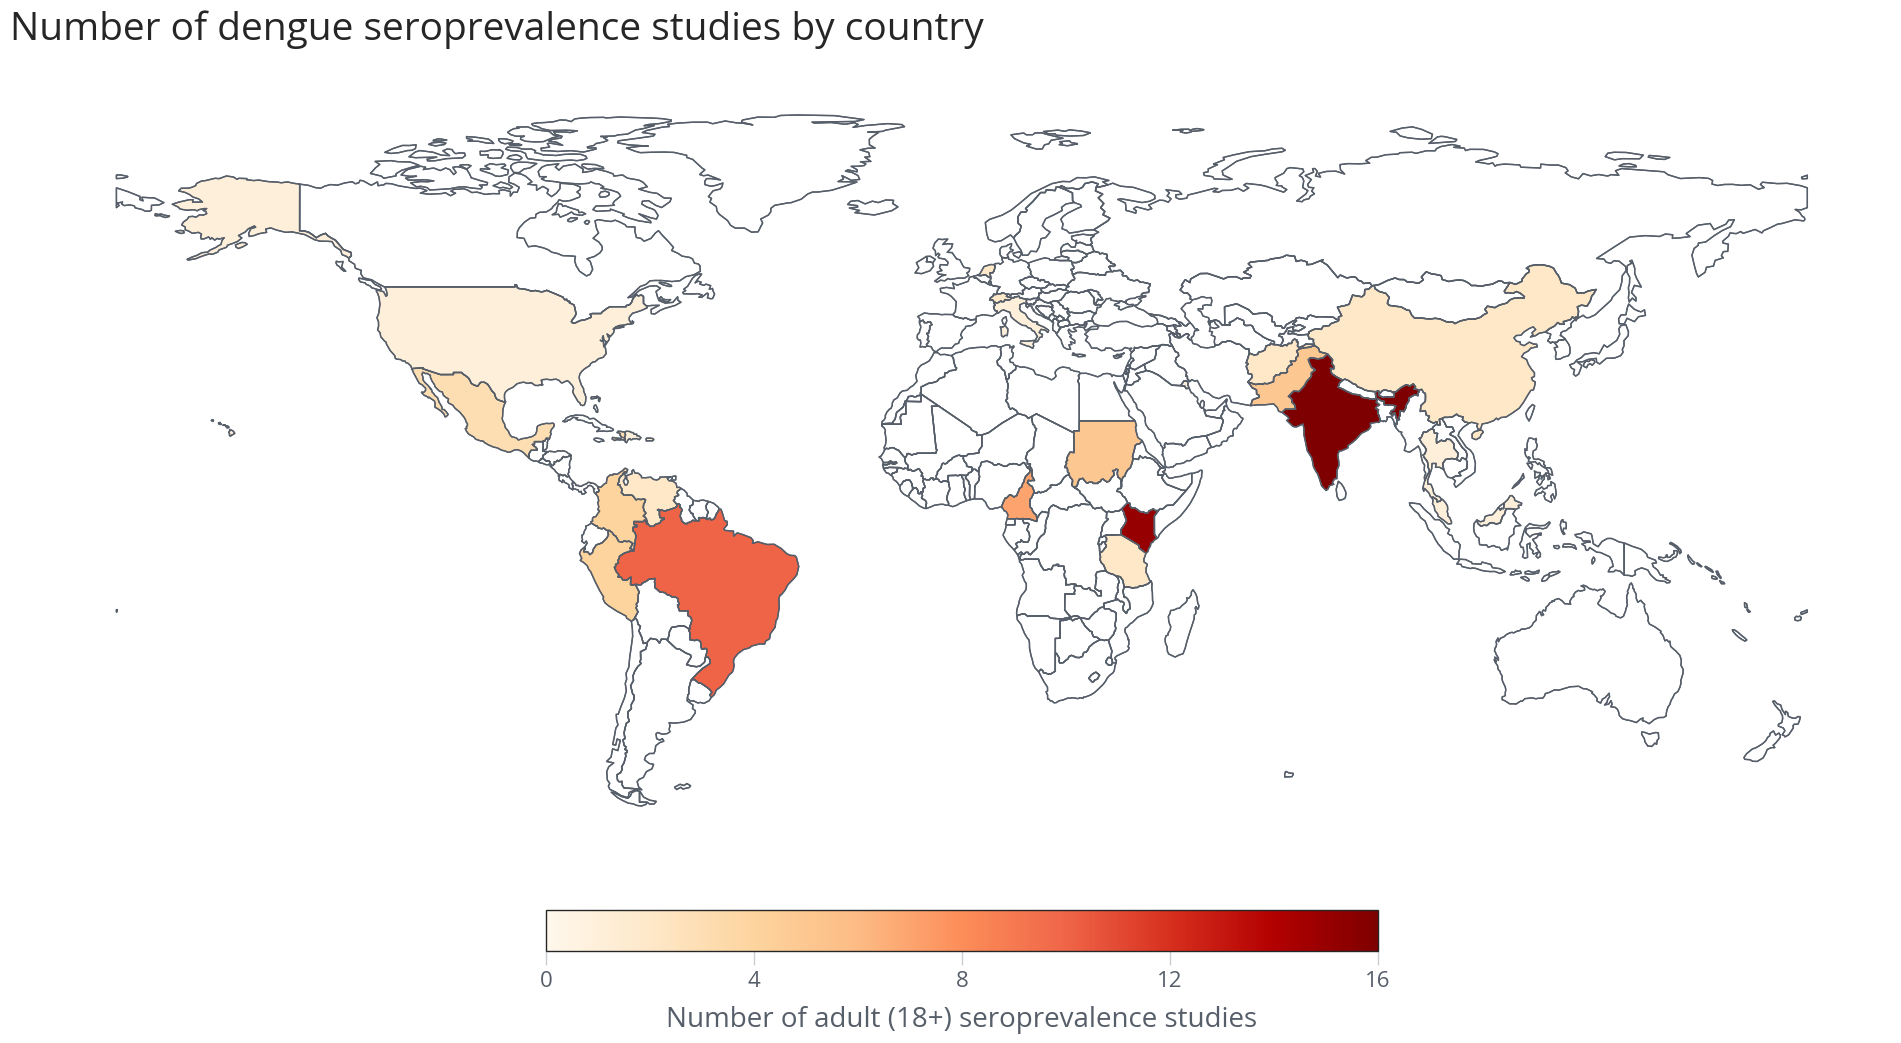

In [6]:
# Ensure the correct geometry column is set
adults_geo = adults_geo.set_geometry('geometry') 

# Create a new figure and axes
fig, ax = plt.subplots(1, 1, figsize=(24, 18))

# Get counts of seroprevalence studies by country
country_sero_counts = adults_geo.groupby('countryAlphaThreeCode').size().reset_index(name='count')

# Merge the count data back with world GDF, drop Antarctica for aesthetics
world_sero_counts = pd.merge(world, country_sero_counts, on='countryAlphaThreeCode', how='left')
world_sero_counts = world_sero_counts[(world_sero_counts.country != "Antarctica")]

# Fill any NaN values with 0 (if some countries have no rows in the data)
world_sero_counts['count'] = world_sero_counts['count'].fillna(0)

# Plot the map with some borders
world_sero_counts.boundary.plot(ax=ax, linewidth=1, color=chart[1])

world_sero_counts[world_sero_counts['count'] == 0].plot(ax=ax, color='white', linewidth=1, edgecolor=chart[1])

# Define the colormap and the range of values
cmap = plt.get_cmap("OrRd")
vmin = 0  # Minimum value for the colorbar
vmax = world_sero_counts['count'].max()  # Maximum value in the dataset

# Plot
world_sero_counts[world_sero_counts['count'] > 0].plot(column='count', cmap="OrRd", legend=False, ax=ax, linewidth=1, edgecolor=chart[1],vmin=vmin, vmax=vmax)

# Create the colorbar
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for ScalarMappable

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.03, pad=0.05)
cbar.set_label('Number of adult (18+) seroprevalence studies', fontsize=20, labelpad = 10)
cbar.ax.tick_params(labelsize=16)  # Adjust the tick label size

# Customize tick values based on the maximum count
tick_values = [0, 4, 8, 12, 16]  # Adjust the step value as needed
cbar.set_ticks(tick_values)

# Set the tick labels for the colorbar
cbar.set_ticklabels([str(tick) for tick in tick_values])  # Convert to string for labeling

# Adjust margins and set title
ax.margins(x=0.05)
ttl = ax.set_title('Number of dengue seroprevalence studies by country', fontsize=28)
ttl.set_position([0.25, 1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')


# Save the figure
plt.savefig('../output/figures/num_seroprevalence_studies.png', dpi=800, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')


### What's the total mean seroprevalence by country?

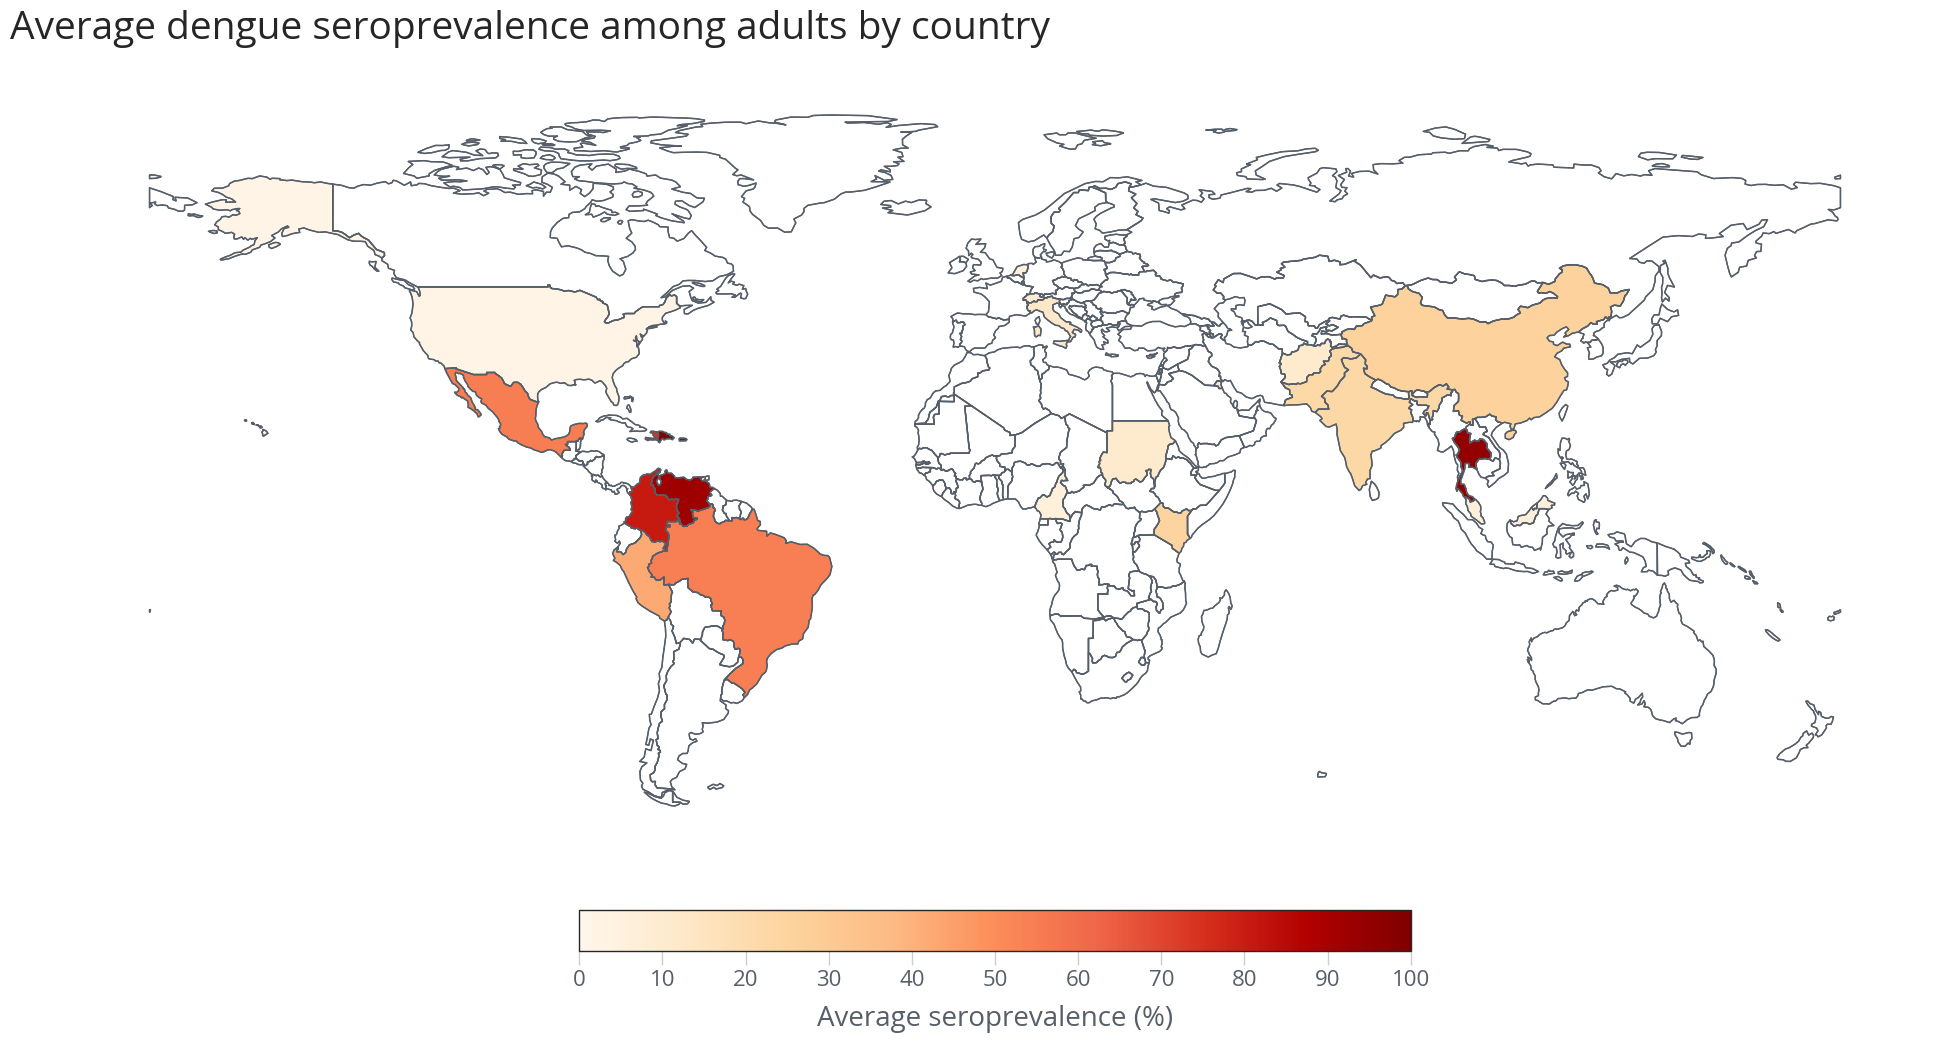

In [7]:
# Ensure the correct geometry column is set
adults_geo = adults_geo.set_geometry('geometry') 

# Create a new figure and axes
fig, ax = plt.subplots(1, 1, figsize=(24, 18))

# Get average seroprevalence by country
country_sero_avg = adults_geo.groupby('countryAlphaThreeCode')['seroprevalence'].mean().reset_index(name='mean_seroprevalence')
country_sero_avg['mean_seroprevalence'] = country_sero_avg["mean_seroprevalence"]*100

# Merge the mean data back with world GDF, drop Antarctica for aesthetics
world_sero_avg = pd.merge(world, country_sero_avg, on='countryAlphaThreeCode', how='left')
world_sero_avg = world_sero_avg[(world_sero_avg.country != "Antarctica")]

# Fill any NaN values with 0 (if some countries have no rows in the data)
world_sero_avg['mean_seroprevalence'] = world_sero_avg['mean_seroprevalence'].fillna(0)

# Plot the map with some borders
world_sero_avg.boundary.plot(ax=ax, linewidth=1, color=chart[1])

world_sero_avg[world_sero_avg['mean_seroprevalence'] == 0].plot(ax=ax, color='white', linewidth=1, edgecolor=chart[1])

# Define the colormap and the range of values
cmap = plt.get_cmap("OrRd")
vmin = 0  # Minimum value for the colorbar
vmax = 100  # Maximum value in the dataset

# Plot
world_sero_avg[world_sero_avg['mean_seroprevalence'] > 0].plot(column='mean_seroprevalence', cmap="OrRd", legend=False, ax=ax, linewidth=1, edgecolor=chart[1],vmin=vmin, vmax=vmax)

# Create the colorbar
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for ScalarMappable

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.03, pad=0.05)
cbar.set_label('Average seroprevalence (%)', fontsize=20, labelpad = 10)
cbar.ax.tick_params(labelsize=16)  # Adjust the tick label size

# Customize tick values
tick_values = [0,10,20,30,40,50,60,70,80,90,100]  # Adjust the step value as needed
cbar.set_ticks(tick_values)

# Set the tick labels for the colorbar
cbar.set_ticklabels([str(tick) for tick in tick_values])  # Convert to string for labeling

# Adjust margins and set title
ax.margins(x=0.05)
ttl = ax.set_title('Average dengue seroprevalence among adults by country', fontsize=28)
ttl.set_position([0.25, 1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')

# Save the figure
plt.savefig('../output/figures/mean_seroprevalence_country.png', dpi=800, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')


### What's the total mean seroprevalence and confidence interval by country over time?

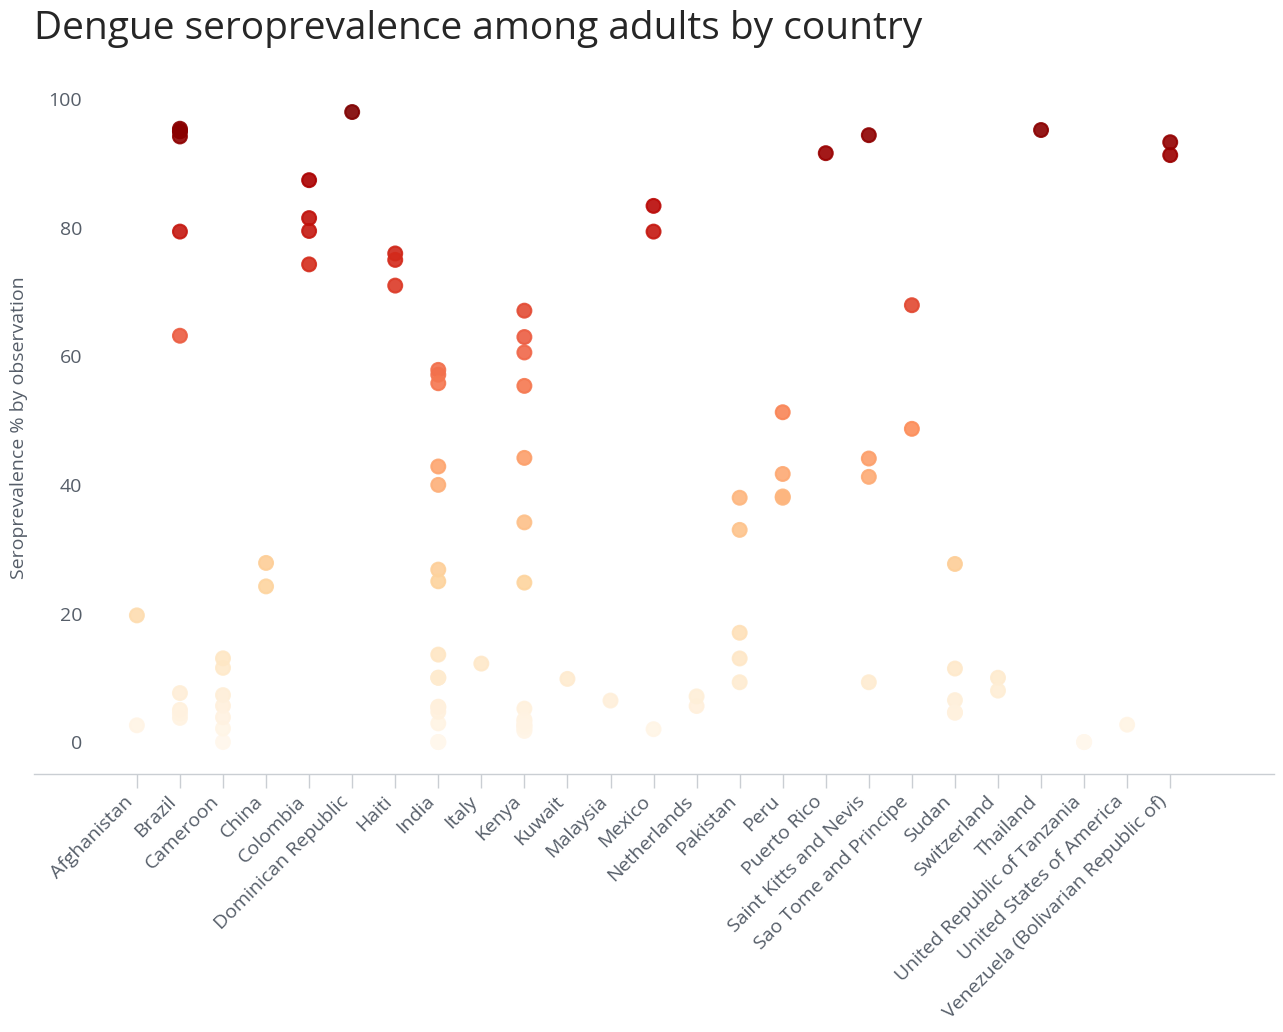

In [37]:
# Define the OrRd colormap
cmap = plt.get_cmap('OrRd')

# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])

# Calculate seroprevalence percentage
adult_sero['seroprevalence_percent'] = adult_sero["seroprevalence"] * 100

# Drop rows with missing seroprevalence data
adult_sero = adult_sero.dropna(subset=['seroprevalence_percent'])

# Prepare data for plotting
x = adult_sero["country"]
y = adult_sero["seroprevalence_percent"]

# Normalize the values to map to the colormap
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
colors = cmap(norm(y) if len(y) > 0 else [0])  # Apply the colormap, ensure colors match y's length

# Plot dots with varying colors
plot = plt.scatter(x=x, y=y, color=colors, s=100, alpha=0.9, zorder=5)

# Set title
title = "Dengue seroprevalence among adults by country"
plt.title(title, fontdict={'fontsize': 28}, loc='left')

# Set x-axis label
plt.xlabel("")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.ylabel('Seroprevalence % by observation')

# # Create the colorbar
# vmin = 0  # Minimum value for the colorbar
# vmax = 100  # Maximum value in the dataset
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Empty array for ScalarMappable

# # Add the colorbar to the figure
# cbar = fig.colorbar(sm, ax=ax, fraction=0.03, orientation='vertical')
# cbar.set_label('Seroprevalence (%)', fontsize=14, labelpad=-80)

# # Customize tick values
# tick_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Adjust as needed
# cbar.set_ticks(tick_values)

# # Set the tick labels for the colorbar
# cbar.set_ticklabels([str(tick) for tick in tick_values])  # Convert to string for labeling

# # Remove the border of the colorbar
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(pad=10)  # Increase the padding to move ticks further away from the colorbar

# # Adjust margins and set title
# plt.tight_layout()
# plt.show()

# Save the figure
plt.savefig('../output/figures/seroprevalence_country.png', dpi=800, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
